100
Execution time of _full_qtf_6dof: 0.0160


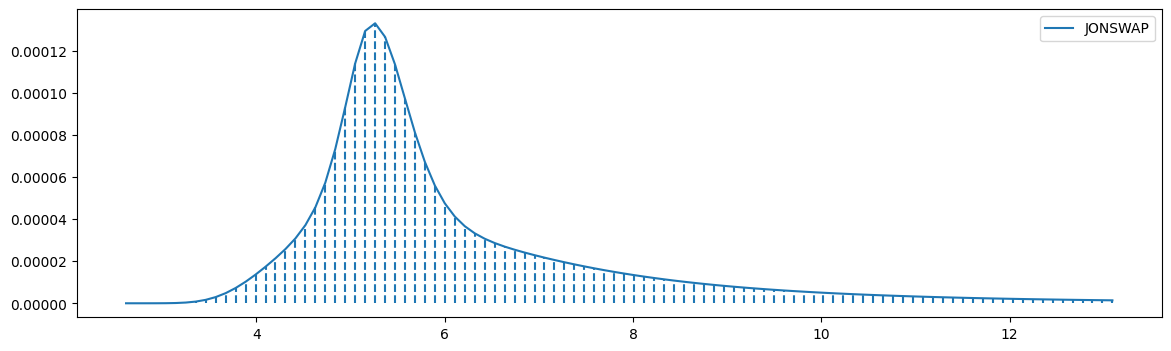

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import utils

plt.rcParams.update({
    'figure.figsize': (12, 4),
    'font.size': 10,
    'lines.linewidth': 1.5
})

from simulator.csad import CSAD_DP_6DOF

from waves import wave_loads, wave_spectra

# Set up intial conditions for CSAD MODEL

seed = np.random.seed(1234)

dt = 0.01
simtime = 60 * 1
t = np.arange(0, simtime, dt)

vessel = CSAD_DP_6DOF(dt)

x = np.zeros((len(t), 12))
eta = np.zeros((len(t), 6))


# Set up environmental loads - waves and current

# CURRENT
Uc = 0.0
betac = 0

# WAVES
hs = 0.06
tp = 1.2
wp = 2*np.pi/tp
gamma = 3.3 # Jonswap spectra is to be used.

wmin = wp/2
wmax = 2.5*wp
N = 100         # Number of wave components

dw = (wmax - wmin)/N

wave_freqs = np.linspace(wmin, wmax, N)


jonswap = wave_spectra.JONSWAP(wave_freqs)
freqs, spectrum = jonswap(hs, tp, gamma=gamma)

wave_amp = np.sqrt(2*spectrum*dw)

phases = np.random.uniform(0, 2*np.pi, size=N)
wave_angle = np.ones(N)*np.deg2rad(45)    # Waves coming from South West

# Now we can pass this to the wave_load module
waveload = wave_loads.WaveLoad(wave_amp, wave_freqs, phases, wave_angle, vessel._config_file)

plt.figure(figsize=(14, 4))
plt.plot(freqs, spectrum, label="JONSWAP")
plt.vlines(x=freqs, ymin=np.zeros(freqs.shape[0]), ymax=spectrum, linestyles="--")
plt.legend()
plt.show()



In [42]:
# RUN SIMULATION
tau_env = np.zeros((len(t), 6))
tau_wf = np.zeros((len(t), 6))
for i in range(1, len(t)):
    # Tau env is the 2nd order wave loads now.
    relative_angle = vessel.get_eta()[-1] - wave_angle[0]
    print(np.rad2deg(relative_angle))
    tau_env[i] = waveload.second_order_loads(t[i], relative_angle)
    tau_wf[i] = waveload.first_order_loads(t[i], relative_angle, vessel.get_eta())
    vessel.x_dot(Uc, betac, tau_env[i] + tau_wf[i])
    vessel.integrate()
    eta[i] = vessel.get_eta()
    x[i] = vessel._x

# Convert from rad and rad/s to deg and deg/s
x[:, 3:6] = np.rad2deg(x[:, 3:6])
x[:, 9:] = np.rad2deg(x[:, 9:])

-45.0
Execution time of second_order_loads: 0.0040
Execution time of first_order_loads: 0.0000
-45.0
Execution time of second_order_loads: 0.0030
Execution time of first_order_loads: 0.0000
-45.00095282651792
Execution time of second_order_loads: 0.0030
Execution time of first_order_loads: 0.0000
-45.002871133552816
Execution time of second_order_loads: 0.0030
Execution time of first_order_loads: 0.0000
-45.00599168722881
Execution time of second_order_loads: 0.0020
Execution time of first_order_loads: 0.0010
-45.01032642736942
Execution time of second_order_loads: 0.0030
Execution time of first_order_loads: 0.0000
-45.01588393405955
Execution time of second_order_loads: 0.0040
Execution time of first_order_loads: 0.0000
-45.022669397961124
Execution time of second_order_loads: 0.0040
Execution time of first_order_loads: 0.0000
-45.0306845954215
Execution time of second_order_loads: 0.0020
Execution time of first_order_loads: 0.0000
-45.03992786858703
Execution time of second_order_loa

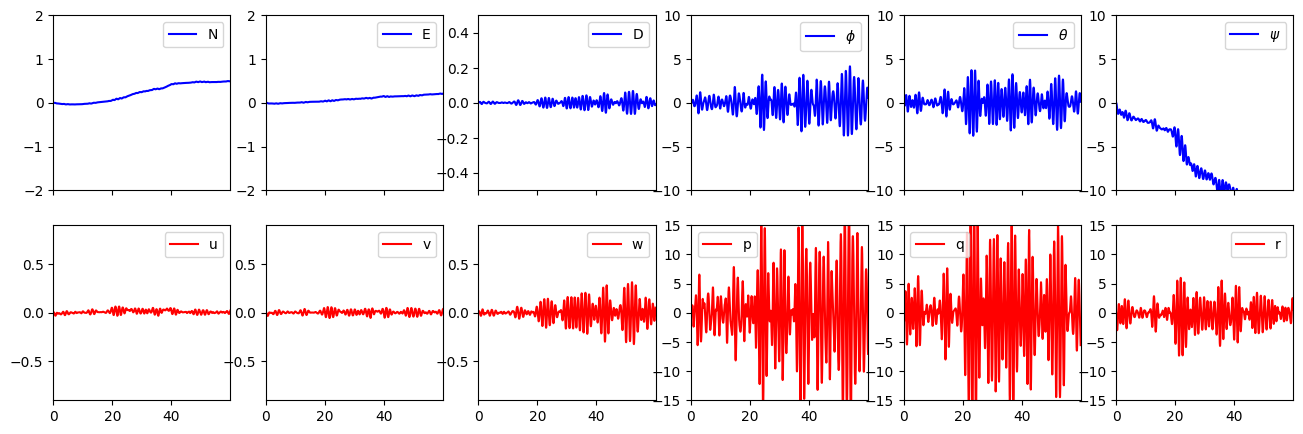

In [43]:
# Plot results
fig, axs = plt.subplots(2, 6, sharex=True, figsize=(16, 5))
labels = ['N', 'E', 'D', r'$\phi$', r"$\theta$", r"$\psi$", "u", "v", "w", 'p', 'q', 'r']
colors = 6*['blue'] + 6*['red']
ylims = [
    (-2, 2),
    (-2, 2),
    (-.5, 0.5),
    (-10, 10),
    (-10, 10),
    (-10, 10),
    (-.9, .9),
    (-.9, .9),
    (-.9, .9),
    (-15, 15),
    (-15, 15),
    (-15, 15),
]
for i in range(12):
    plt.sca(axs[i//6, i - 6*(i//6)])
    plt.plot(t, x[:, i], color=colors[i], label=labels[i])
    plt.ylim(ylims[i])
    plt.xlim(t[0], t[-1])
    plt.legend()

plt.show()

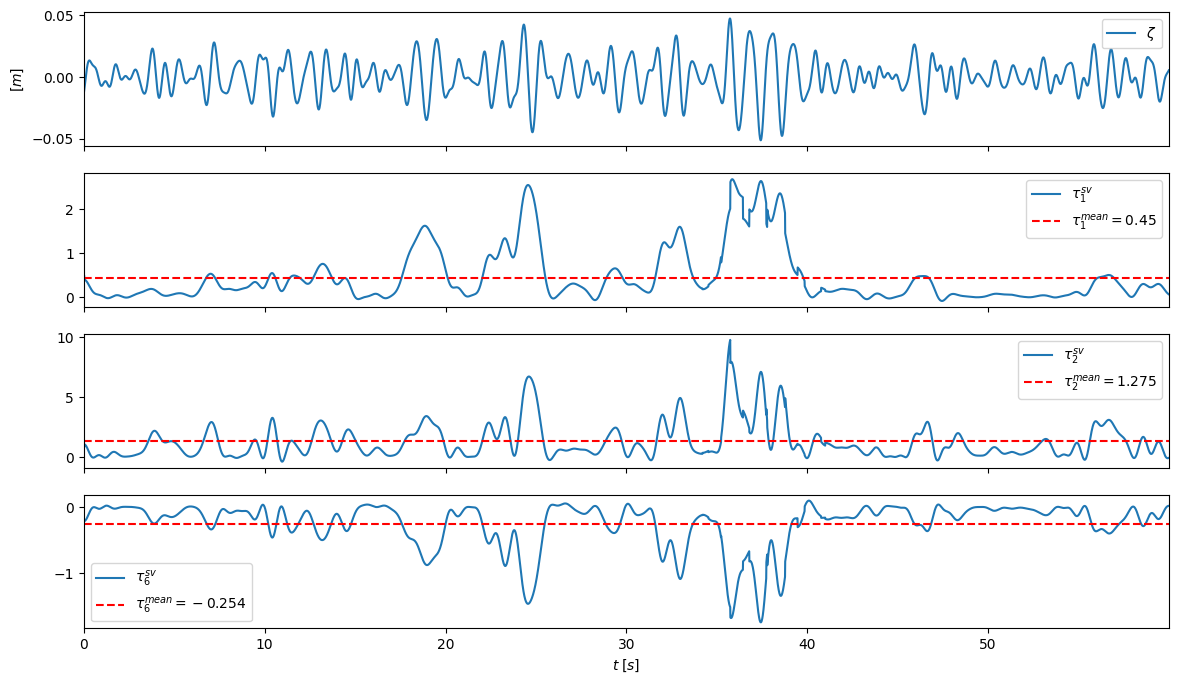

In [44]:
# Plot the slowly varying load for the different DoF
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 8))
c = 1

plt.sca(axs[0])
plt.plot(t, np.sum(wave_amp*np.cos(wave_freqs*t[:, None] + phases), axis=1), label=r"$\zeta$")
plt.ylabel("$[m]$")
plt.legend()
for i in [0, 1, 5]:
    plt.sca(axs[c])
    plt.plot(t, tau_env[:, i], label=r"$\tau_{}^{}$".format(i+1, '{sv}'))
    avg = np.round(np.mean(tau_env[:, i]),3)
    plt.axhline(avg, linestyle="--", color="red", label=r"$\tau_{}^{}={}$".format(i+1, '{mean}', avg))
    plt.legend()
    c += 1

plt.xlabel("$t \; [s]$")
plt.xlim(t[0], t[-1])
plt.show()

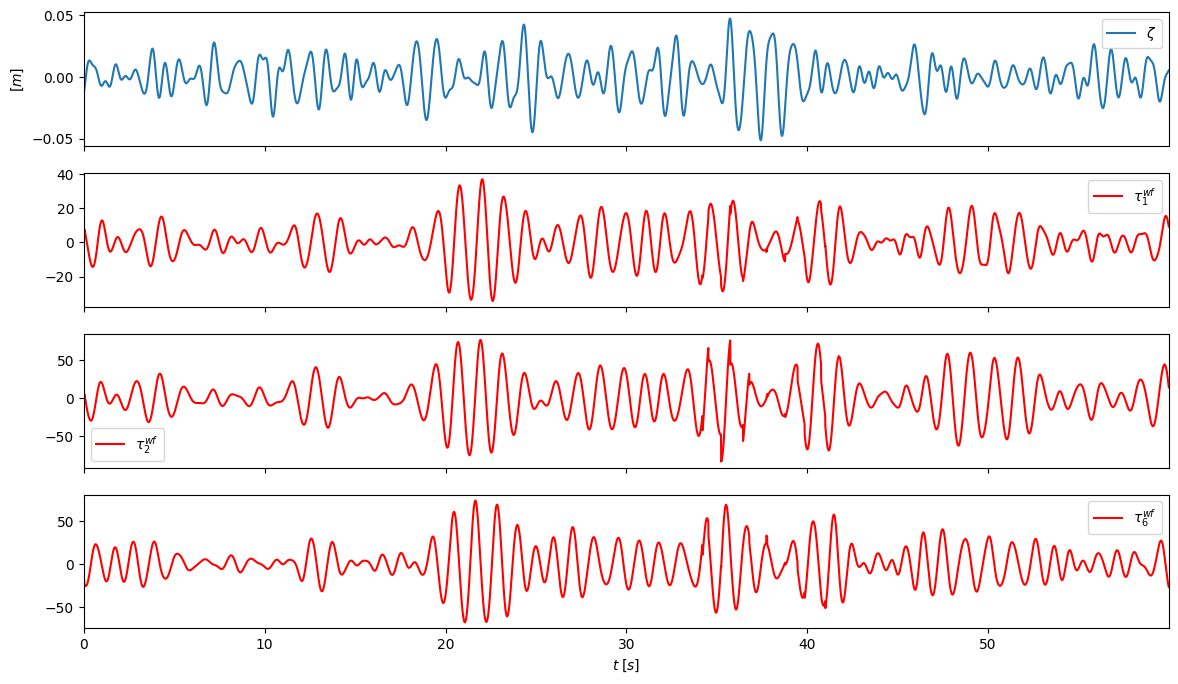

In [45]:
# Plot the wave-frequency loads for the different DoF
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 8))
c = 1

plt.sca(axs[0])
plt.plot(t, np.sum(wave_amp*np.cos(wave_freqs*t[:, None] + phases), axis=1), label=r"$\zeta$")
plt.ylabel("$[m]$")
plt.legend()
for i in [0, 1, 5]:
    plt.sca(axs[c])
    plt.plot(t, tau_wf[:, i], 'r-', label=r"$\tau_{}^{}$".format(i+1, '{wf}'))
    avg = np.round(np.mean(tau_env[:, i]),2)
    #plt.axhline(avg, linestyle="--", color="red", label=r"$\tau_{}^{}={}$".format(i+1, '{mean}', avg))
    plt.legend()
    c += 1

plt.xlabel("$t \; [s]$")
plt.xlim(t[0], t[-1])
plt.show()

In [46]:
print(np.round(vessel._D, 2))

[[ 3.6060e+01  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  2.8259e+02  0.0000e+00  2.3000e+00  0.0000e+00  3.5800e+00]
 [ 0.0000e+00  0.0000e+00  7.3416e+02  0.0000e+00  8.9830e+01  0.0000e+00]
 [ 0.0000e+00  2.3000e+00  0.0000e+00  3.3300e+00  0.0000e+00 -5.2000e-01]
 [ 0.0000e+00  0.0000e+00  8.9830e+01  0.0000e+00  3.5486e+02  0.0000e+00]
 [ 0.0000e+00  3.5800e+00  0.0000e+00 -5.2000e-01  0.0000e+00  9.9110e+01]]


In [47]:
print(np.round(vessel._Dp, 2))

[[ 1.9630e+01  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  1.5382e+02  0.0000e+00  2.3000e+00  0.0000e+00  3.5800e+00]
 [ 0.0000e+00  0.0000e+00  7.3416e+02  0.0000e+00  8.9830e+01  0.0000e+00]
 [ 0.0000e+00  2.3000e+00  0.0000e+00  1.3000e-01  0.0000e+00 -5.2000e-01]
 [ 0.0000e+00  0.0000e+00  8.9830e+01  0.0000e+00  3.5486e+02  0.0000e+00]
 [ 0.0000e+00  3.5800e+00  0.0000e+00 -5.2000e-01  0.0000e+00  4.8600e+01]]


In [48]:
print(f"Natural Frequencies [rad/s]".center(80, '-'))
wn = np.sqrt(vessel._G/vessel._M)
wn[np.isnan(wn)] = 0
print(np.round(wn, 2))
print(f"Natural Period".center(80, '-'))
tn = 2*np.pi/wn
tn[np.isinf(tn)] = 0
print(np.round(tn, 2))

--------------------------Natural Frequencies [rad/s]---------------------------
[[ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.    0.    0.  ]
 [ 0.    0.    5.59  0.    5.74  0.  ]
 [ 0.   -0.    0.    4.24  0.    0.  ]
 [ 0.    0.    5.74  0.    5.65  0.  ]
 [ 0.    0.    0.   -0.    0.    0.  ]]
---------------------------------Natural Period---------------------------------
[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.12 0.   1.1  0.  ]
 [0.   0.   0.   1.48 0.   0.  ]
 [0.   0.   1.1  0.   1.11 0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


C:\Users\j-ehy\AppData\Local\Temp\ipykernel_22564\3910662644.py:2: RuntimeWarning: invalid value encountered in divide
  wn = np.sqrt(vessel._G/vessel._M)
C:\Users\j-ehy\AppData\Local\Temp\ipykernel_22564\3910662644.py:2: RuntimeWarning: invalid value encountered in sqrt
  wn = np.sqrt(vessel._G/vessel._M)
C:\Users\j-ehy\AppData\Local\Temp\ipykernel_22564\3910662644.py:6: RuntimeWarning: divide by zero encountered in divide
  tn = 2*np.pi/wn


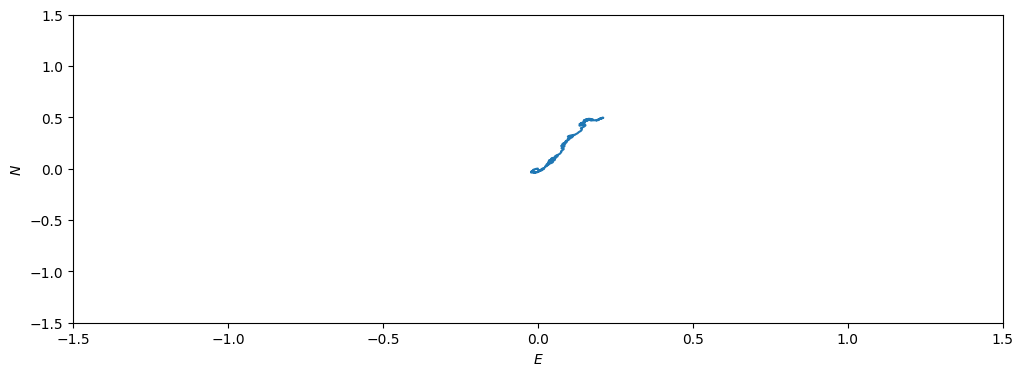

In [49]:
plt.plot(x[:, 1], x[:, 0])
plt.xlabel("$E$")
plt.ylabel("$N$")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

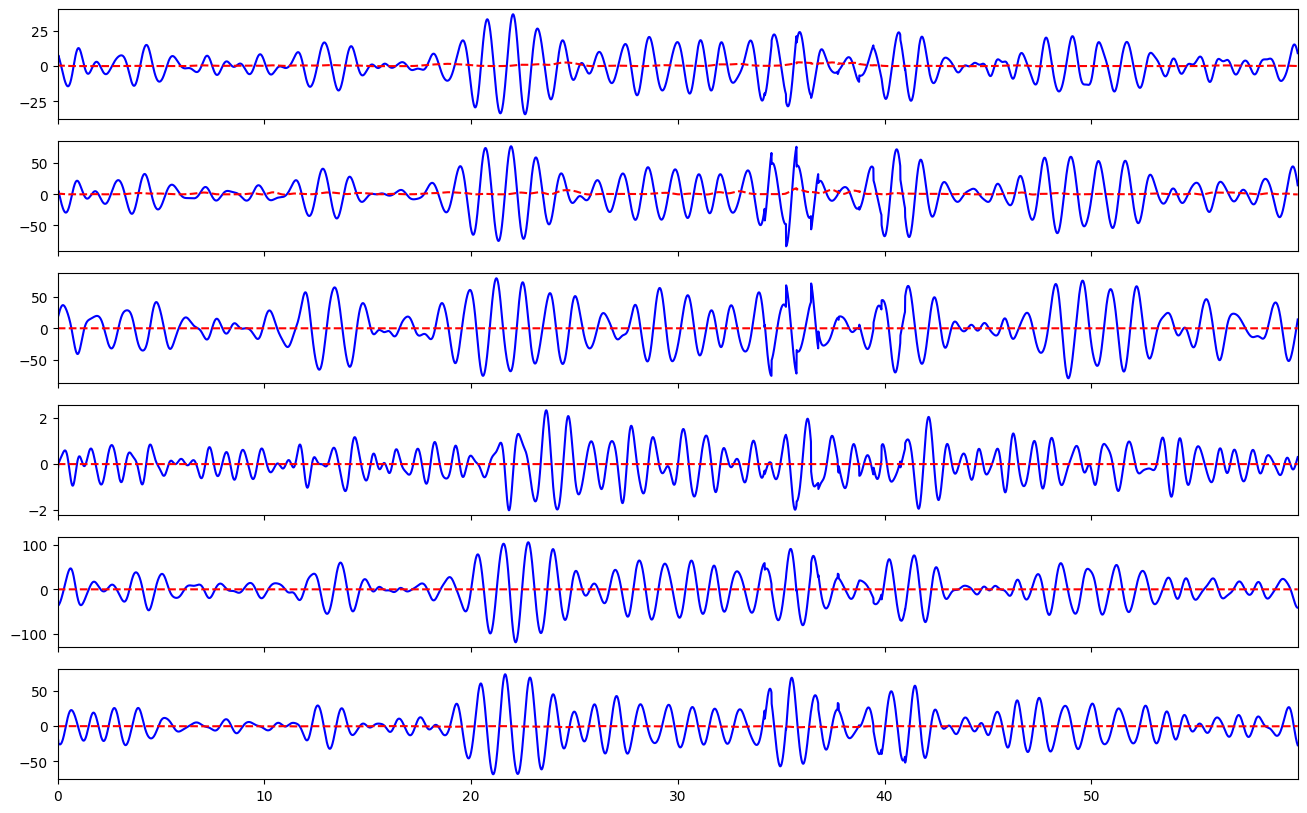

In [50]:
fig, ax = plt.subplots(6, 1, sharex=True, figsize=(16, 10))
for i in range(6):
    plt.sca(ax[i])
    plt.plot(t, tau_wf[:, i], "b-")
    plt.plot(t, tau_env[:, i], 'r--')
plt.xlim(t[0], t[-1])
plt.show()